In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import pickle
import random
import cv2

In [57]:
np.random.seed(2222)

In [58]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [59]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data=pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data=pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data=pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [60]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [61]:
all = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]
print('X_train percent = ',round(X_train.shape[0]/all*100, 2))
print('X_val percent = ',round(X_val.shape[0]/all*100, 2))
print('X_test percent = ',round(X_test.shape[0]/all*100, 2))

X_train percent =  67.13
X_val percent =  8.51
X_test percent =  24.36


In [62]:
assert(X_train.shape[0]==y_train.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_val.shape[0]==y_val.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_test.shape[0]==y_test.shape[0]), 'The number of images is not equal to the number of labels'
assert(X_train.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_test.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_val.shape[1:]==(32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'

In [63]:
data=pd.read_csv('german-traffic-signs/signnames.csv')

In [64]:
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


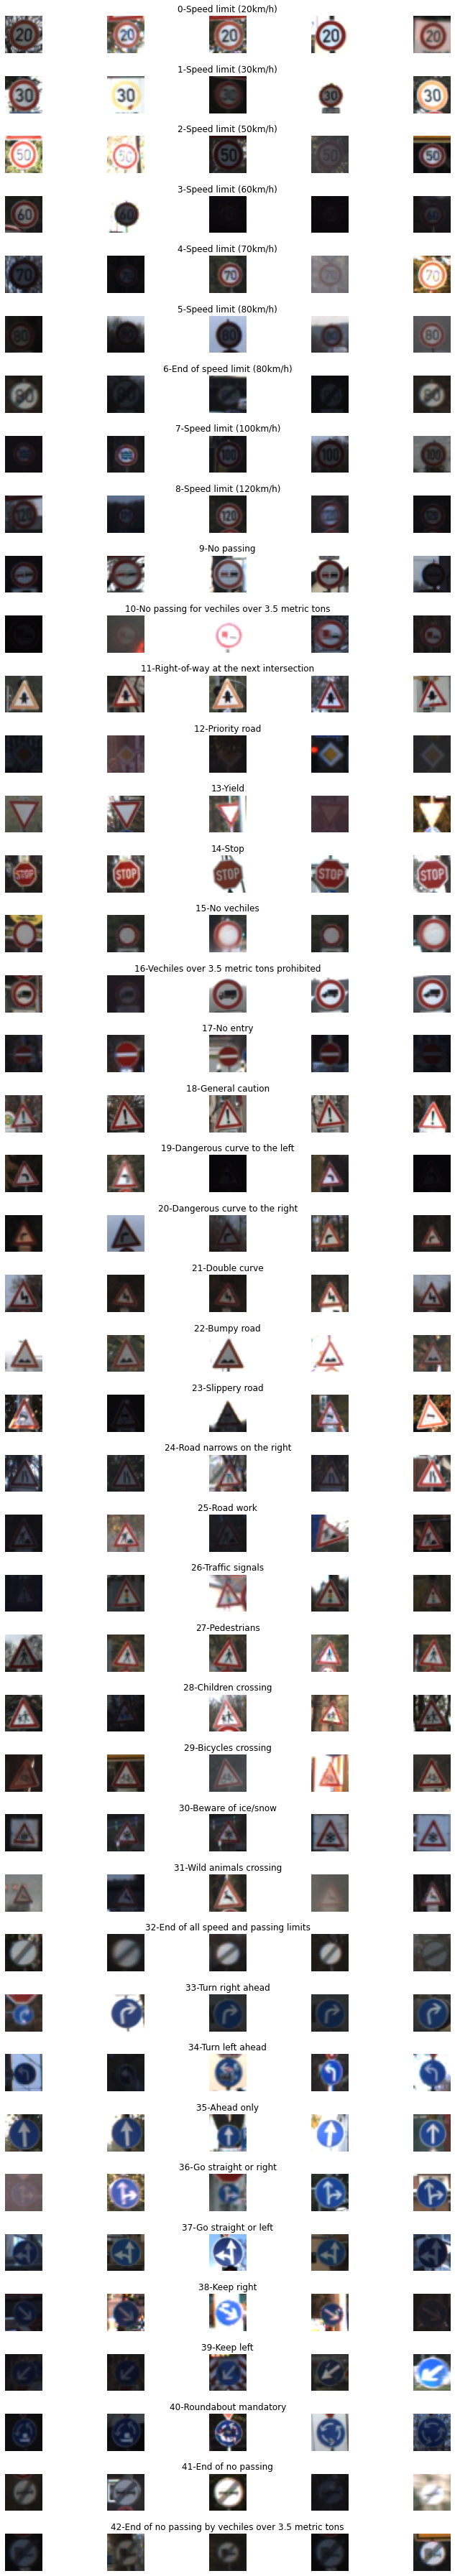

In [66]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(10, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-'+row['SignName'])
            num_of_samples.append(len(x_selected))

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [ ]:
np.std(num_of_samples)

In [213]:
print(np.max(num_of_samples), np.min(num_of_samples))

2010 180


## preprocessing

(32, 32, 3)
31


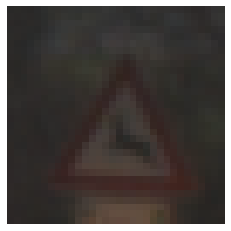

In [14]:
plt.imshow(X_train[222])
plt.axis('off')
print(X_train[222].shape)
print(y_train[222])

### convert to gray

(32, 32)


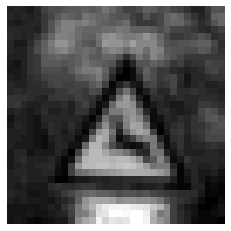

In [15]:
def grayscale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

img = grayscale(X_train[222])
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

### histogram equalization

(32, 32)


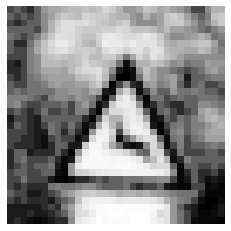

In [16]:
def equalize(img):
    # equalizeHist funciont only accept gray images
    equalized_img = cv2.equalizeHist(img)
    return equalized_img

img = equalize(img)
print(img.shape)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [17]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train=np.array(list(map(preprocessing, X_train)))
X_val=np.array(list(map(preprocessing, X_val)))
X_test=np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


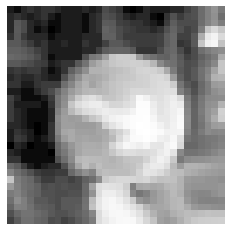

In [18]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)
plt.show()

In [19]:
X_train=X_train.reshape(34799, 32, 32, 1)
X_test=X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val=X_val.reshape(X_val.shape[0], 32, 32, 1)

In [20]:
data_gen=ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
data_gen.fit(X_train)

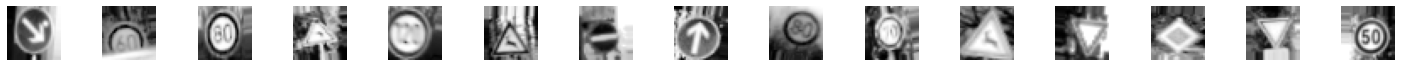

In [21]:
batches = data_gen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)
fig, ax = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
    ax[i].imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
    ax[i].axis('off')

In [22]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [23]:
y_train=to_categorical(y_train, 43)
y_test=to_categorical(y_test, 43)
y_val=to_categorical(y_val, 43)

In [238]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [239]:
model = modified_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_23 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                 

In [240]:
history=model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50), steps_per_epoch=len(X_train)//50, epochs=13, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/13


/tmp/ipykernel_2957/2042956763.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50), steps_per_epoch=len(X_train)//50, epochs=13, validation_data=(X_val, y_val), shuffle=True)


695/695 [==============================] - 507s 728ms/step - loss: 1.7435 - accuracy: 0.5008 - val_loss: 0.3540 - val_accuracy: 0.8998
Epoch 2/13
695/695 [==============================] - 482s 693ms/step - loss: 0.5816 - accuracy: 0.8193 - val_loss: 0.1109 - val_accuracy: 0.9701
Epoch 3/13
695/695 [==============================] - 452s 650ms/step - loss: 0.3572 - accuracy: 0.8872 - val_loss: 0.0884 - val_accuracy: 0.9726
Epoch 4/13
695/695 [==============================] - 451s 649ms/step - loss: 0.2651 - accuracy: 0.9166 - val_loss: 0.1115 - val_accuracy: 0.9667
Epoch 5/13
695/695 [==============================] - 465s 669ms/step - loss: 0.2176 - accuracy: 0.9311 - val_loss: 0.0480 - val_accuracy: 0.9873
Epoch 6/13
695/695 [==============================] - 450s 647ms/step - loss: 0.1825 - accuracy: 0.9416 - val_loss: 0.0544 - val_accuracy: 0.9844
Epoch 7/13
695/695 [==============================] - 450s 647ms/step - loss: 0.1591 - accuracy: 0.9504 - val_loss: 0.0436 - val_accura

In [241]:
score=model.evaluate(X_test, y_test, verbose=0)
print('accuracy = ', round(score[1]*100, 3),'%', '\nloss = ', round(score[0], 3))

accuracy =  96.651 % 
loss =  0.117


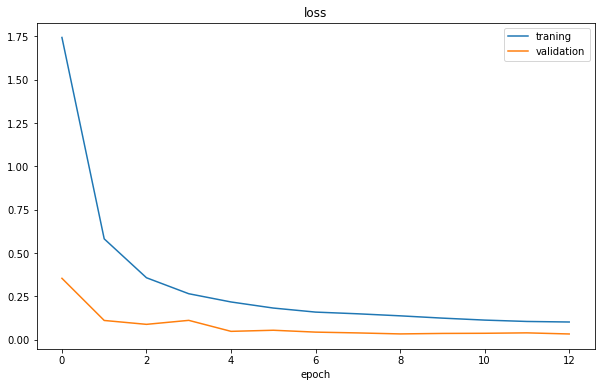

In [242]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

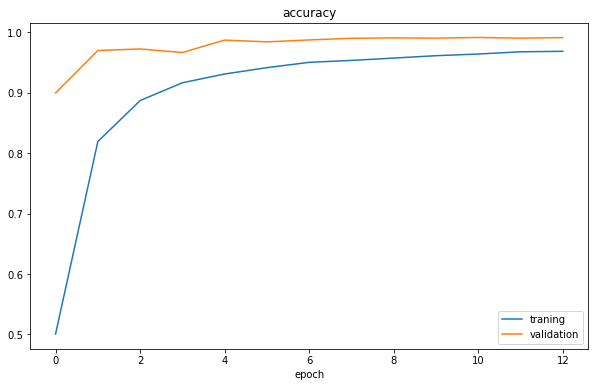

In [243]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['traning', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()

In [244]:
model.save('traffic_signs_model')

INFO:tensorflow:Assets written to: aah/assets


INFO:tensorflow:Assets written to: aah/assets


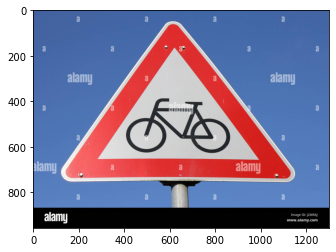

In [51]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
url2 = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url3 = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
url4 = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
url5 = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url5, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

(32, 32)


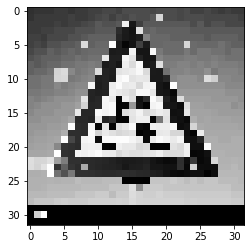

In [52]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [53]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [54]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img))))

1/1 [==============================] - 0s 61ms/step
predicted sign: 29


In [55]:
data.loc[29]['SignName']

'Bicycles crossing'